# Project 7 - Plant Species Identification

### Imports

In [ ]:
# Import necessary modules.

import numpy as np

import tensorflow
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from google.colab.patches import cv2_imshow

import pandas as pd
import keras
import zipfile as zf
import os
from glob import glob
import seaborn as sns

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
%cd /gdrive/'My Drive'

/gdrive/My Drive


In [ ]:
pwd


'/gdrive/My Drive'

### Data File Extraction

In [ ]:
file = zf.ZipFile('plant-seedlings-classification.zip')
file.extractall()
#file = zf.ZipFile('train.zip')
#file.extractall()
TRAIN_DATA_FOLDER = 'train'

### Observe Distribution ofImages

In [ ]:
images = []
classes =[]
missing=0
for class_folder_name in os.listdir(TRAIN_DATA_FOLDER):
    class_folder_path = os.path.join(TRAIN_DATA_FOLDER, class_folder_name)
    class_label = class_folder_name
    
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image_bgr is None: # if the file contain any missig value ignore it
          missing += 1
          continue
        images.append(image_bgr)
        
        classes.append(class_label)

In [ ]:
def resize_images(img):
  img = np.array(img).astype(np.uint8)
  res = cv2.resize(img,(256,256), interpolation = cv2.INTER_CUBIC)
  return res

In [ ]:
images = [resize_images(img) for img in images]

In [ ]:
#see number of images in each lablel
images = np.array(images)
classes = np.array(classes)
for label in set(classes):
  print("number of {} images are :  {}".format(label, len(images[classes == label])))

number of Loose Silky-bent images are :  654
number of Cleavers images are :  287
number of Charlock images are :  390
number of Common wheat images are :  221
number of Sugar beet images are :  385
number of Common Chickweed images are :  611
number of Shepherds Purse images are :  231
number of Maize images are :  221
number of Scentless Mayweed images are :  516
number of Fat Hen images are :  475
number of Small-flowered Cranesbill images are :  496
number of Black-grass images are :  263


Text(0.5, 0.98, 'Categorical Plotting')

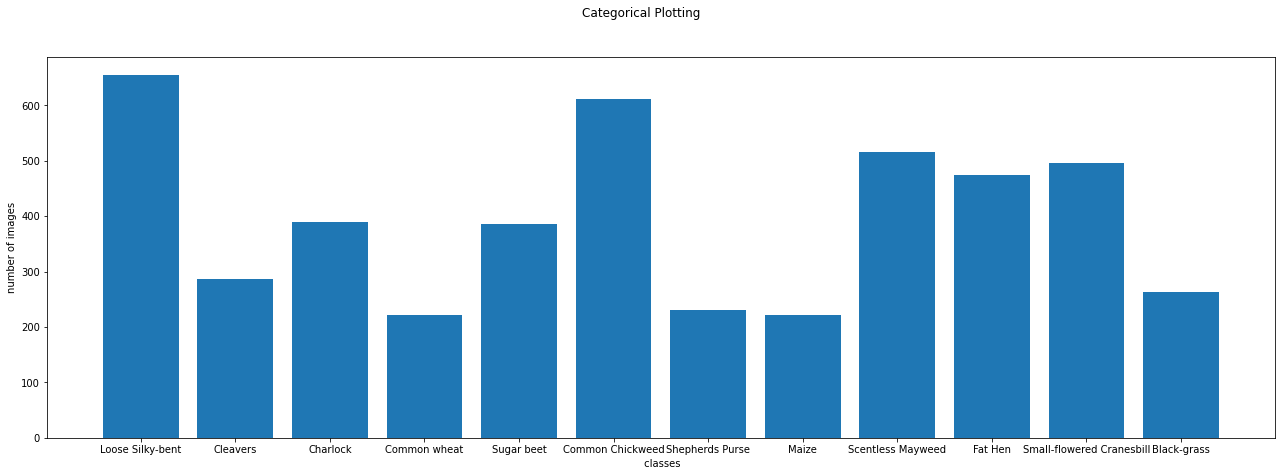

In [ ]:
#plot the distrbution of number of images
values =[]
labels=[]
for label in set(classes):
  values.append(len(images[classes == label]))
  labels.append(label)

fig, ax = plt.subplots(figsize=(22,7))
ax.bar(labels, values)
ax.set_xlabel(" classes")
ax.set_ylabel("number of images")
#axs[1].scatter(label, )
  #axs[2].plot(names, values)
fig.suptitle('Categorical Plotting')

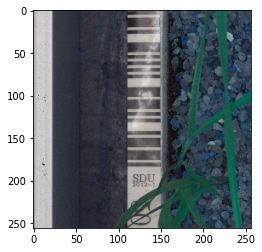

In [ ]:
plt.imshow(images[42])

### Image Pre-Process

In [ ]:
#Image pre processings functions
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp
  
def segment(img):
  image_segmented = segment_plant(img)
  image_sharpen = sharpen_image(image_segmented)
  return image_sharpen

In [ ]:
for indx, image in enumerate(images):
    images[indx] = segment(image)

### Model

In [ ]:
from sklearn.preprocessing import LabelBinarizer
y = LabelBinarizer().fit_transform(classes)
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3, random_state=7)

In [ ]:
X_test, X_val, y_test, Y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=7)

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5), activation ='relu', batch_input_shape = (5,256, 256, 3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), activation ='relu'))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.2))


model.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', activation ='relu'))

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, kernel_size = (3,3),activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3), activation ='relu'))

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Dropout(0.4))

model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation = "relu"))

model.add(Dropout(0.5))

model.add(Dense(12, activation = "softmax"))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (5, 252, 252, 32)         2432      
_________________________________________________________________
conv2d_14 (Conv2D)           (5, 248, 248, 32)         25632     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (5, 124, 124, 32)         0         
_________________________________________________________________
dropout_9 (Dropout)          (5, 124, 124, 32)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (5, 122, 122, 64)         18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (5, 122, 122, 64)         36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (5, 61, 61, 64)          

In [ ]:
opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = 'Adam', loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
model.fit(X_train, y_train, epochs =3 , validation_data = (X_val,Y_val),batch_size = 5)

Train on 3325 samples, validate on 713 samples
Epoch 1/3
3325/3325 [==============================] - 2032s 611ms/step - loss: 2.6390 - accuracy: 0.1353 - val_loss: 2.3601 - val_accuracy: 0.1846
Epoch 2/3
3325/3325 [==============================] - 1985s 597ms/step - loss: 2.1582 - accuracy: 0.2322 - val_loss: 2.0977 - val_accuracy: 0.2531
Epoch 3/3
3325/3325 [==============================] - 2010s 604ms/step - loss: 1.9987 - accuracy: 0.2556 - val_loss: 2.0177 - val_accuracy: 0.2657


In [ ]:
#Y_pred = model.predict(X_val)

In [ ]:
#predicted_classes = model.predict_classes(X_test)

Predicted label: 8
1.0


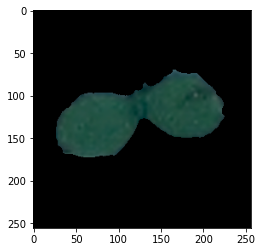

In [ ]:
%matplotlib inline
plt.imshow(X_test[2].reshape(256,256,3))
y_pred1 = model.predict(X_test[2].reshape(1, 256, 256, 3))
print("Predicted label:", y_pred1.argmax())
print(y_pred1.sum())

Predicted label: 8


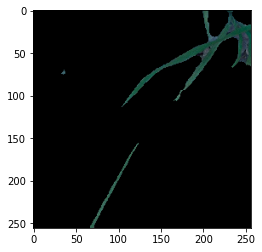

In [ ]:
%matplotlib inline
plt.imshow(X_test[3].reshape(256,256,3))
y_pred2 = model.predict(X_test[2].reshape(1, 256, 256, 3))
print("Predicted label:", y_pred2.argmax())


Predicted label: 6


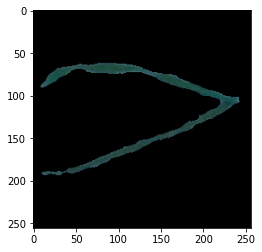

In [ ]:
%matplotlib inline
plt.imshow(X_test[33].reshape(256,256,3))
y_pred3 = model.predict(X_test[33].reshape(1, 256, 256, 3))
print("Predicted label:", y_pred3.argmax())

Predicted label: 3


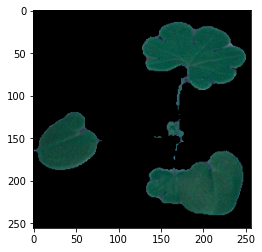

In [ ]:
%matplotlib inline
plt.imshow(X_test[36].reshape(256,256,3))
y_pred4 = model.predict(X_test[36].reshape(1, 256, 256, 3))
print("Predicted label:", y_pred4.argmax())

Predicted label: 8


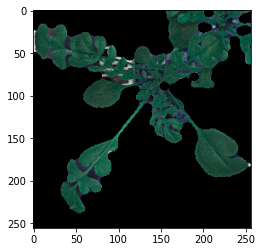

In [ ]:
%matplotlib inline
plt.imshow(X_test[59].reshape(256,256,3))
y_pred5 = model.predict(X_test[59].reshape(1, 256, 256, 3))
print("Predicted label:", y_pred5.argmax())